# TP Large Scale Kernel Methods

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_svmlight_file

## Chargement et partitionnement des données

In [2]:
###############################################################################
# Requires file ijcnn1.dat.gz to be present in the directory

dataset_path = 'ijcnn1.dat.gz'
ijcnn1 = load_svmlight_file(dataset_path)
X = ijcnn1[0].todense()
y = ijcnn1[1]

###############################################################################
# Extract features

X_train, X_test, y_train, y_test = train_test_split(X[:60000, :], y[:60000],
                     train_size=20000, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

n_train, p = X_train.shape
n_test = X_test.shape[0]

print("Nombre d'exemples d'apprentissage:", n_train)
print("Nombre d'exemples de test:", n_test)
print("Nombre de features:", p)

Nombre d'exemples d'apprentissage: 20000
Nombre d'exemples de test: 40000
Nombre de features: 22


/home/aurelien/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Question 1

On va fitter nos données d'apprentissage avec un SVM linéaire et un SVM non-linéaire (noyau Gaussien) pour comparer leur score de prédiction ainsi que le temps de calcul nécessaire à l'apprentissage et à la prédiction.

In [3]:
from sklearn.svm import SVC, LinearSVC
from time import time

print("Fitting SVC rbf on %d samples..." % X_train.shape[0])
t0 = time()
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC rbf on %d samples..." % X_test.shape[0])
t1 = time()
accuracy_kernel = clf.score(X_test, y_test)
print("done in %0.3fs" % (time() - t1))
timing_kernel = time() - t0
print("classification accuracy: %0.3f" % accuracy_kernel)


print("Fitting SVC linear on %d samples..." % X_train.shape[0])
t0 = time()
clf_fast = LinearSVC(dual=False)
clf_fast.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % X_test.shape[0])
t1 = time()
accuracy_linear = clf_fast.score(X_test, y_test)
timing_linear = time() - t0
print("done in %0.3fs" % (time() - t1))
print("classification accuracy: %0.3f" % accuracy_linear)


Fitting SVC rbf on 20000 samples...
done in 5.215s
Predicting with SVC rbf on 40000 samples...
done in 5.444s
classification accuracy: 0.980
Fitting SVC linear on 20000 samples...
done in 0.087s
Predicting with SVC linear on 40000 samples...
done in 0.007s
classification accuracy: 0.917


On voit que la version noyau du SVM obtient un score de prédiction bien meilleur, mais au prix d'un temps de calcul 10 à 100 fois supérieur à la fois en apprentissage et en prédiction sur le test.

## Question 2

On code une fonction qui calcule la meilleure approximation de rang $k$.

In [4]:
from scipy.sparse.linalg import svds
from scipy.linalg import svd

def rank_trunc(gram_mat, k, fast=True):
    """
    k-th order approximation of the Gram Matrix G.

    Parameters
    ----------
    gram_mat : array, shape (n_samples, n_samples)
        the Gram matrix
    k : int
        the order approximation
    fast : bool
        use svd (if False) or svds (if True).

    Return
    ------
    gram_mat_k : array, shape (n_samples, n_samples)
        The rank k Gram matrix.
    """
    if fast:
        u, s, vt = svds(gram_mat, k)
        gram_mat_k = np.dot(u, np.dot(np.diag(s), vt))
    else:
        u, s, vt = svd(gram_mat, full_matrices=False)
        gram_mat_k = np.dot(u[:, :k], np.dot(np.diag(s[:k]), vt[:k, :]))

    return gram_mat_k


## Question 3

On applique cette fonction sur la matrice décrite dans le sujet de TP.

In [5]:
p = 200
r_noise = 100
r_signal = 20

intensity = 50

rng = np.random.RandomState(42)
X_noise = rng.randn(r_noise, p)
X_signal = rng.randn(r_signal, p)

gram_signal = np.dot(X_noise.T, X_noise) + intensity * np.dot(X_signal.T,
                                                              X_signal)
n_ranks = 100
ranks = np.arange(1, n_ranks + 1)
timing_fast = np.zeros(n_ranks)
timing_slow = np.zeros(n_ranks)
rel_error = np.zeros(n_ranks)

for k, rank in enumerate(ranks):
    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=True)
    timing_fast[k] = time() - t0

    t0 = time()
    gram_mat_k = rank_trunc(gram_signal, rank, fast=False)
    timing_slow[k] = time() - t0

    rel_error[k] = linalg.norm(gram_mat_k - gram_signal, 'fro') / \
        linalg.norm(gram_signal, 'fro')

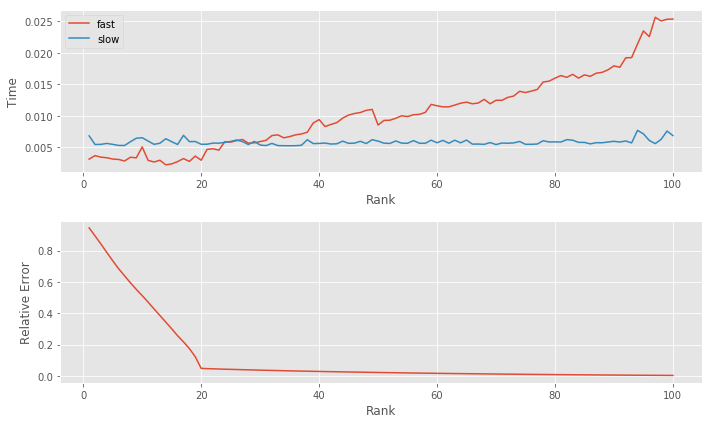

In [6]:
###############################################################################
# Display

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks, timing_fast, '-', label='fast')
ax1.plot(ranks, timing_slow, '-', label='slow')
ax1.legend()

ax1.set_xlabel('Rank')
ax1.set_ylabel('Time')
ax2.plot(ranks, rel_error, '-')
ax2.set_xlabel('Rank')
ax2.set_ylabel('Relative Error')
plt.tight_layout()
plt.show()

Au niveau du temps de calcul, on voit que la méthode "fast" est plus rapide uniquement quand le rang $k$ recherché est faible, sinon elle est en fait plus lente que "slow". Cela vient du fait que "slow" calcule la décomposition SVD complète puis applique le seuillage pour ne garder que les $k$ plus grands facteurs. Son coût de calcul est donc indépendant de $k$. En revanche, "fast" utilise une méthode itérative (une version améliorée de la power method) : elle calcule les $k$ plus grands facteurs les uns après les autres. Cela est efficace seulement si on cherche un faible nombre de facteurs ($k \ll p$), et que ceux-ci sont bien "séparés".

En ce qui concerne l'erreur, on voit qu'elle décroit fortement jusqu'au rang 20, après quoi elle est infime. Cela vient du fait de la structure de la matrice, qui est approximativement de rang 20 ($G=50G^{signal}+G^{noise}$ où la matrice $G^{signal}$ est exactement de rang 20 et domine largement $G^{noise}$ qui est elle de rang 100). Au delà de 20, les valeurs propres deviennent très faibles et très proches, ce qui explique aussi que la version "fast" devienne beaucoup plus lente.

## Question 4

On va implémenter l'algorithme de Random Kernel Features pour le noyau Gaussien.

In [7]:
def random_features(X_train, X_test, gamma, c=300, seed=44):
    """Compute random kernel features

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples, n_features = X_train.shape
    sigma = np.sqrt(1. / (2. * gamma))

    W_gaussian = 1. / sigma * rng.randn(n_features, c)
    b = 2. * np.pi * rng.rand(c)

    X_new_train = np.sqrt(2. / c) * np.cos(np.dot(X_train, W_gaussian) + b)
    X_new_test = np.sqrt(2. / c) * np.cos(np.dot(X_test, W_gaussian) + b)
    return X_new_train, X_new_test

## Question 5

On va maintenant appliquer cette méthode avec $c=300$.

In [8]:
n_samples, n_features = X_train.shape
n_samples_test, _ = X_test.shape
gamma = 1. / n_features


Z_train, Z_test = random_features(X_train, X_test, gamma, c=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)

Fitting SVC linear on 20000 samples...
done in 1.184s
Predicting with SVC linear on 40000 samples...
done in 0.014s
classification accuracy: 0.963


En utilisant la technique des RKF avec $c=300$ features, on obtient un score de prédiction proche de celui du noyau Gaussien exact (et bien supérieur à celui d'un SVM linéaire), tout en ayant très fortement réduit le temps d'apprentissage et de prédiction.

## Question 6

On implémente la méthode de Nystrom.

In [9]:
from sklearn.metrics.pairwise import rbf_kernel

def nystrom(X_train, X_test, gamma, c=500, k=200, seed=44):
    """Compute nystrom kernel approximation

    Parameters
    ----------
    X_train : array, shape (n_samples1, n_features)
        The train samples.
    X_test : array, shape (n_samples2, n_features)
        The test samples.
    gamma : float
        The Gaussian kernel parameter
    c : int
        The number of points to sample for the approximation
    k : int
        The number of components
    seed : int
        The seed for random number generation

    Return
    ------
    X_new_train : array, shape (n_samples1, c)
        The new train samples.
    X_new_test : array, shape (n_samples2, c)
        The new test samples.
    """
    rng = np.random.RandomState(seed)
    n_samples = X_train.shape[0]
    idx = rng.choice(n_samples, c)

    X_train_idx = X_train[idx, :]
    W = rbf_kernel(X_train_idx, X_train_idx, gamma=gamma)

    # Could svds but returns NaNs too easily...
    V, s, _ = svd(W)
    V = V[:, :k]
    s = s[:k]

    M_k = V / np.sqrt(s[np.newaxis, :])

    C_train = rbf_kernel(X_train, X_train_idx, gamma=gamma)
    X_new_train = np.dot(C_train, M_k)

    C_test = rbf_kernel(X_test, X_train_idx, gamma=gamma)
    X_new_test = np.dot(C_test, M_k)

    return X_new_train, X_new_test

## Question 7

On va maintenant appliquer cette méthode également avec $c=500$ et $k=300$

In [10]:
Z_train, Z_test = nystrom(X_train, X_test, gamma, c=500, k=300, seed=44)

print("Fitting SVC linear on %d samples..." % n_samples)
t0 = time()
clf = LinearSVC(dual=False)
clf.fit(Z_train, y_train)
print("done in %0.3fs" % (time() - t0))

print("Predicting with SVC linear on %d samples..." % n_samples_test)
t0 = time()
accuracy = clf.score(Z_test, y_test)
print("done in %0.3fs" % (time() - t0))
print("classification accuracy: %0.3f" % accuracy)


Fitting SVC linear on 20000 samples...
done in 0.932s
Predicting with SVC linear on 40000 samples...
done in 0.013s
classification accuracy: 0.976


Là encore, avec un faible nombre de features pour approximer le noyau, on atteint un score proche du noyau Gaussien exact avec un temps de calcul pour l'apprentissage et la prédiction fortement réduit.

## Question 8

On va maintenant réaliser une synthèse des performances des RKF et de Nystrom pour un ensemble de paramètres.

In [11]:
ranks = np.arange(20, 600, 50)
n_ranks = len(ranks)
timing_rkf = np.zeros(n_ranks)
timing_nystrom = np.zeros(n_ranks)

accuracy_nystrom = np.zeros(n_ranks)
accuracy_rkf = np.zeros(n_ranks)

print("Training SVMs for various values of c...")

for i, c in enumerate(ranks):
    print(i, c)
    t0 = time()
    Z_train, Z_test = nystrom(X_train, X_test, gamma, c=c, k=c-10, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_nystrom[i] = clf.score(Z_test, y_test)
    timing_nystrom[i] = time() - t0

    t0 = time()
    Z_train, Z_test = random_features(X_train, X_test, gamma, c=c, seed=44)
    clf = LinearSVC(dual=False)
    clf.fit(Z_train, y_train)
    accuracy_rkf[i] = clf.score(Z_test, y_test)
    timing_rkf[i] = time() - t0


Training SVMs for various values of c...
0 20
1 70
2 120
3 170
4 220
5 270
6 320
7 370
8 420
9 470
10 520
11 570


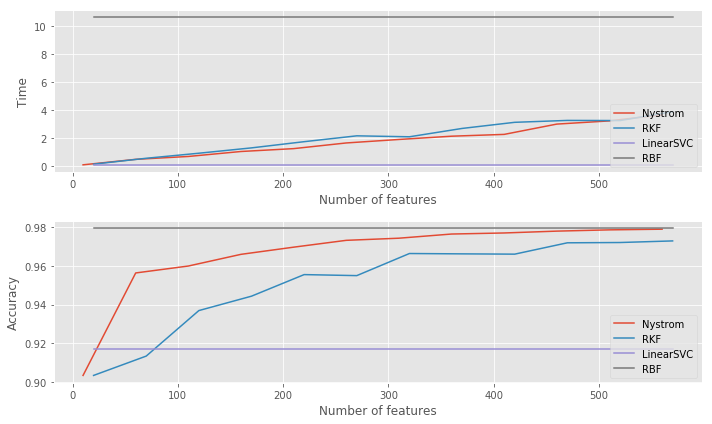

In [12]:
###############################################################################
# Display bis

f, axes = plt.subplots(ncols=1, nrows=2, figsize=(10,6))
ax1, ax2 = axes.ravel()

ax1.plot(ranks-10, timing_nystrom, '-', label='Nystrom')
ax1.plot(ranks, timing_rkf, '-', label='RKF')
ax1.plot(ranks, timing_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax1.plot(ranks, timing_kernel * np.ones(n_ranks), '-', label='RBF')

ax1.set_xlabel('Number of features')
ax1.set_ylabel('Time')
ax1.legend(loc='lower right')

ax2.plot(ranks-10, accuracy_nystrom, '-', label='Nystrom')
ax2.plot(ranks, accuracy_rkf, '-', label='RKF')
ax2.plot(ranks, accuracy_linear * np.ones(n_ranks), '-', label='LinearSVC')
ax2.plot(ranks, accuracy_kernel * np.ones(n_ranks), '-', label='RBF')
ax2.set_xlabel('Number of features')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='lower right')
plt.tight_layout()
plt.show()

On voit que le coût en temps de calcul pour RKF et Nystrom est similaire pour un nombre de features donné (ceci dépend des implémentations, il existe des manières plus efficaces de générer les RKF qui les rendent dans ce cas plus rapides à générer que Nystrom). Par ailleurs, Nystrom permet de meilleurs scores de prédiction que RKS pour un nombre de features donné, bien que l'on voit que les deux courbes convergent vers le score du noyau Gaussien exact. Il suffit de très peu de features pour dépasser le noyau linéaire.